## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Visualized Dataset

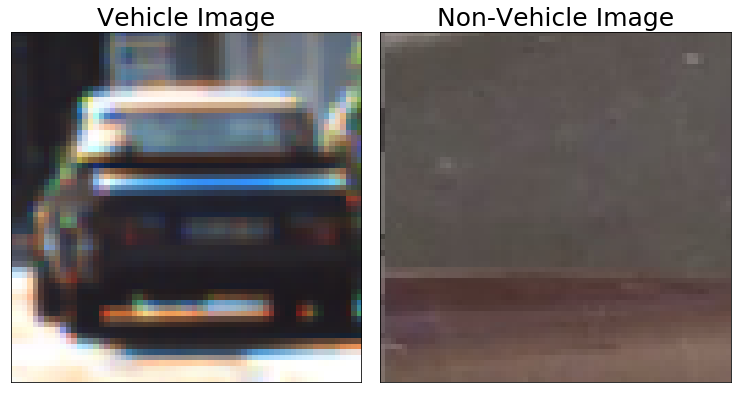

In [1]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

#plt.figure(figsize=(10,40))
# plt.subplot(1,2,1)
vehicle = plt.imread('../../dataset/vehicles/KITTI_extracted/1.png')
# plt.imshow(vehicle)
# plt.title('Vehicle')
# plt.xticks([])
# plt.yticks([])

# plt.subplot(1,2,2)
non_vehicle = plt.imread('../../dataset/non-vehicles/Extras/extra5.png')
# plt.imshow(non_vehicle)
# plt.title('Non-Vehicle')
# 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# plt.xticks([])
# plt.yticks([])
plt.setp((ax1, ax2),xticks=[],yticks=[])
f.tight_layout()
ax1.imshow(vehicle)
ax1.set_title('Vehicle Image', fontsize=25)
ax2.imshow(non_vehicle)
ax2.set_title('Non-Vehicle Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Features Extraction Function

In [2]:
import cv2
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Hog Feature and Visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32), hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat is True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat is True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return all feature vector
    return features

## Histogram of Oriented Gradients

/home/joseph/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


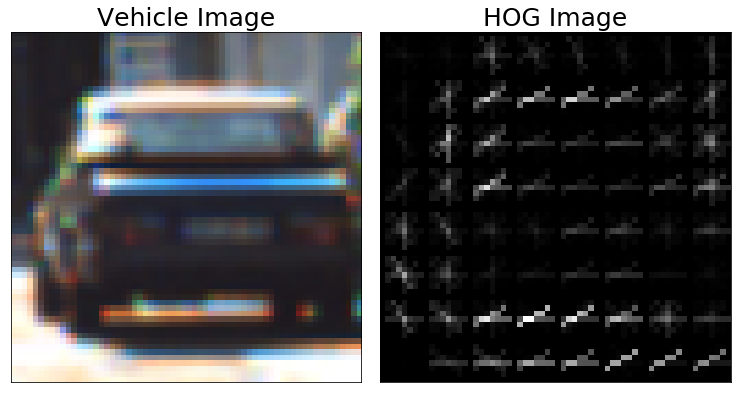

In [3]:
features, hog = get_hog_features(vehicle[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
plt.setp((ax1, ax2),xticks=[],yticks=[])
f.tight_layout()
ax1.imshow(vehicle)
ax1.set_title('Vehicle Image', fontsize=25)
ax2.imshow(hog, cmap='gray')
ax2.set_title('HOG Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Draw Bounding Box

In [3]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size,
              hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2' + color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(hog_channel, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch

            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

    return draw_img

## Loading Trained Classifier

/home/joseph/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


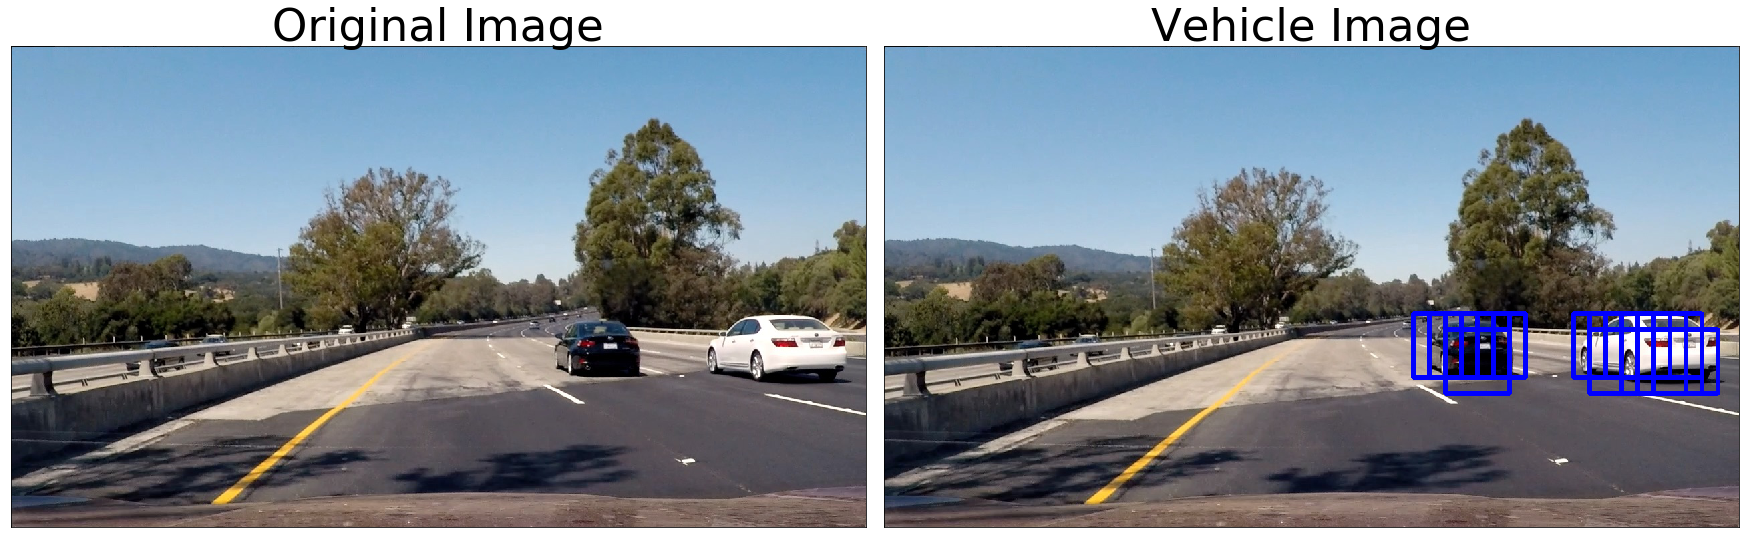

In [4]:
import pickle 

## Load model params
with open('model.pk', 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    for key in pickle_data:
        exec(key + "= pickle_data['" + str(key) + "']")
    del pickle_data

img = mpimg.imread('test_images/test4.jpg')


ystart = 400
ystop = 656
scale = 1.5
   
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
plt.setp((ax1, ax2),xticks=[],yticks=[])
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=45)
ax2.imshow(out_img)
ax2.set_title('Vehicle Image', fontsize=45)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Multi-Scale Search

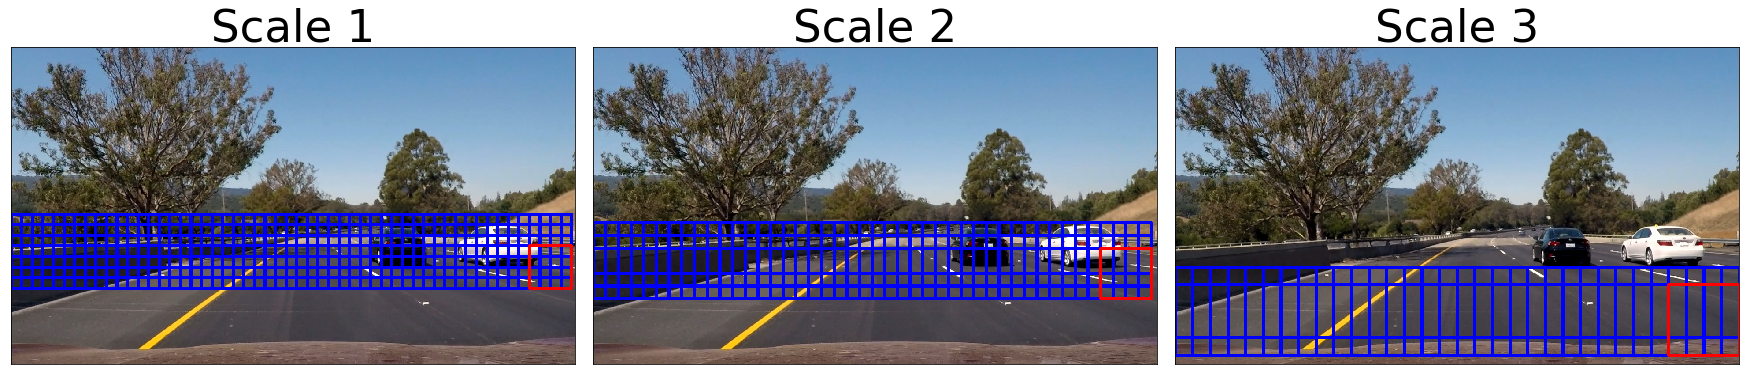

In [5]:
def draw_multi_scale_windows(img, ystart, ystop, scale):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    imshape = img_tosearch.shape
    img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2

    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    rect_start = None
    rect_end = None
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            rect_start = (xbox_left, ytop_draw + ystart)
            rect_end = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
            cv2.rectangle(draw_img, rect_start, rect_end, (0, 0, 255), 6)
    
    cv2.rectangle(draw_img, rect_start, rect_end, (255, 0, 0), 6)

    return draw_img

img = mpimg.imread('test_images/test6.jpg')

# plt.figure(figsize=(15,40))
# subpltcount=1
# for (ystart, ystop, scale) in [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]:
#     plt.subplot(1,3,subpltcount)
#     plt.imshow(draw_multi_scale_windows(img, ystart, ystop, scale))
#     plt.title('Scale %s'%subpltcount)
#     plt.xticks([])
#     plt.yticks([])
#     subpltcount +=1

scale1 = draw_multi_scale_windows(img, 380, 560, 1.5)
scale2 = draw_multi_scale_windows(img, 400, 600, 1.8)
scale3 = draw_multi_scale_windows(img, 500, 700, 2.5)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
plt.setp((ax1, ax2, ax3),xticks=[],yticks=[])
f.tight_layout()
ax1.imshow(scale1)
ax1.set_title('Scale 1', fontsize=45)
ax2.imshow(scale2)
ax2.set_title('Scale 2', fontsize=45)
ax3.imshow(scale3)
ax3.set_title('Scale 3', fontsize=45)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Store frame information in Detection Class

In [6]:
import pickle
from collections import deque

import cv2
from scipy.ndimage.measurements import label

class VehicleDetector:
    def __init__(self, model_param_files):
        # Loading Model Parameters
        with open(model_param_files, 'rb') as pfile:
            pickle_data = pickle.load(pfile)
            for key in pickle_data:
                exec("self." + key + "= pickle_data['" + str(key) + "']")
            del pickle_data

        # Current HeatMap
        self.heatmap = None

        # Heat Image for the Last Three Frames
        self.heat_images = deque(maxlen=3)

        # Current Frame Count
        self.frame_count = 0
        self.full_frame_processing_interval = 10

        # Xstart
        self.xstart = 600

        # Various Scales
        self.ystart_ystop_scale = [(380, 560, 1.5), (400, 600, 1.8), (500, 700, 2.5)]

        # Kernal For Dilation
        self.kernel = np.ones((50, 50))

        # Threshold for Heatmap
        self.threshold = 2

    def find_cars(self, img):
        X_scaler = self.X_scaler
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        svc = self.svc

        box_list = []

        draw_img = np.copy(img)
        img = img.astype(np.float32) / 255

        if self.frame_count % self.full_frame_processing_interval == 0:
            mask = np.ones_like(img[:, :, 0])
        else:
            mask = np.sum(np.array(self.heat_images), axis=0)
            mask[(mask > 0)] = 1
            mask = cv2.dilate(mask, self.kernel, iterations=1)

        self.frame_count += 1

        for (ystart, ystop, scale) in self.ystart_ystop_scale:

            nonzero = mask.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            if len(nonzeroy) != 0:
                ystart = max(np.min(nonzeroy), ystart)
                ystop = min(np.max(nonzeroy), ystop)
            if len(nonzeroy) != 0:
                xstart = max(np.min(nonzerox), self.xstart)
                xstop = np.max(nonzerox)
            else:
                continue

            if xstop <= xstart or ystop <= ystart:
                continue

            img_tosearch = img[ystart:ystop, xstart:xstop, :]
            ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
            if scale != 1:
                imshape = ctrans_tosearch.shape
                ys = np.int(imshape[1] / scale)
                xs = np.int(imshape[0] / scale)
                if (ys < 1 or xs < 1):
                    continue
                ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

            if ctrans_tosearch.shape[0] < 64 or ctrans_tosearch.shape[1] < 64:
                continue

            ch1 = ctrans_tosearch[:, :, 0]
            ch2 = ctrans_tosearch[:, :, 1]
            ch3 = ctrans_tosearch[:, :, 2]

            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // pix_per_cell) - 1
            nyblocks = (ch1.shape[0] // pix_per_cell) - 1
            nfeat_per_block = orient * cell_per_block ** 2
            # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
            window = 64
            nblocks_per_window = (window // pix_per_cell) - 1
            cells_per_step = 2  # Instead of overlap, define how many cells to step
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step

            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

            for xb in range(nxsteps + 1):
                for yb in range(nysteps + 1):
                    ypos = yb * cells_per_step
                    xpos = xb * cells_per_step

                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    xleft = xpos * pix_per_cell
                    ytop = ypos * pix_per_cell

                    # Extract the image patch
                    subimg = ctrans_tosearch[ytop:ytop + window, xleft:xleft + window]

                    # Get color features
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)

                    # Scale features and make a prediction
                    test_features = X_scaler.transform(
                        np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                    # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
                    test_prediction = svc.predict(test_features)
                    if test_prediction == 1:
                        xbox_left = xstart + np.int(xleft * scale)
                        ytop_draw = np.int(ytop * scale)
                        win_draw = np.int(window * scale)
                        box_list.append(
                            ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

        # Add heat to each box in box list
        self.add_heatmap_and_threshold(draw_img, box_list, self.threshold)

        # Find final boxes from heatmap using label function
        labels = label(self.heatmap)
        VehicleDetector.draw_labeled_bboxes(draw_img, labels)

        return draw_img

    def add_heatmap_and_threshold(self, draw_img, bbox_list, threshold):
        heatmap = np.zeros_like(draw_img[:, :, 0]).astype(np.float)

        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        self.heat_images.append(heatmap)
        self.heatmap = np.sum(np.array(self.heat_images), axis=0)
        self.heatmap[self.heatmap <= threshold] = 0

    @staticmethod
    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)


## Define Processor class to add lane line and bounding box

In [7]:
from utils.line import Line
from utils.pipeline import pipeline
from utils.threshold import *

class Processor(object):
    """
        Image processor utility.
    """
    def __init__(self):
        """
            Returns an image processor utility.
        """
        ## Load camera params
        with open('camera.pk', 'rb') as pfile:
            pickle_data = pickle.load(pfile)
            for key in pickle_data:
                if key == 'M':
                    self.M = pickle_data[key]
                if key == 'Minv':
                    self.Minv = pickle_data[key]
                if key == 'cameraMat':
                    self.cameraMat = pickle_data[key]
                if key == 'distCoeffs':
                    self.distCoeffs = pickle_data[key]
            del pickle_data

        self.finder = VehicleDetector('model.pk')
        self.line = Line()
        
    
    def find_vehicles(self, img):
        self.finder.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
        self.finder.threshold = 3
        result = self.finder.find_cars(img)
        return result
    
    def find_lane(self, img):
        """
            Finds the lane.
        """
        result = pipeline(img, line=self.line, M=self.M, Minv=self.Minv, cameraMat=self.cameraMat
                                 , distCoeffs=self.distCoeffs)
        return result
    
    def get_heatmap(self):
        return self.finder.heat_images[0]
    
    def get_threshold_heatmap(self):
        return self.finder.heatmap
    
    def process(self, img):
        result = self.find_vehicles(img)
        result = self.find_lane(result)
        return result

/home/joseph/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


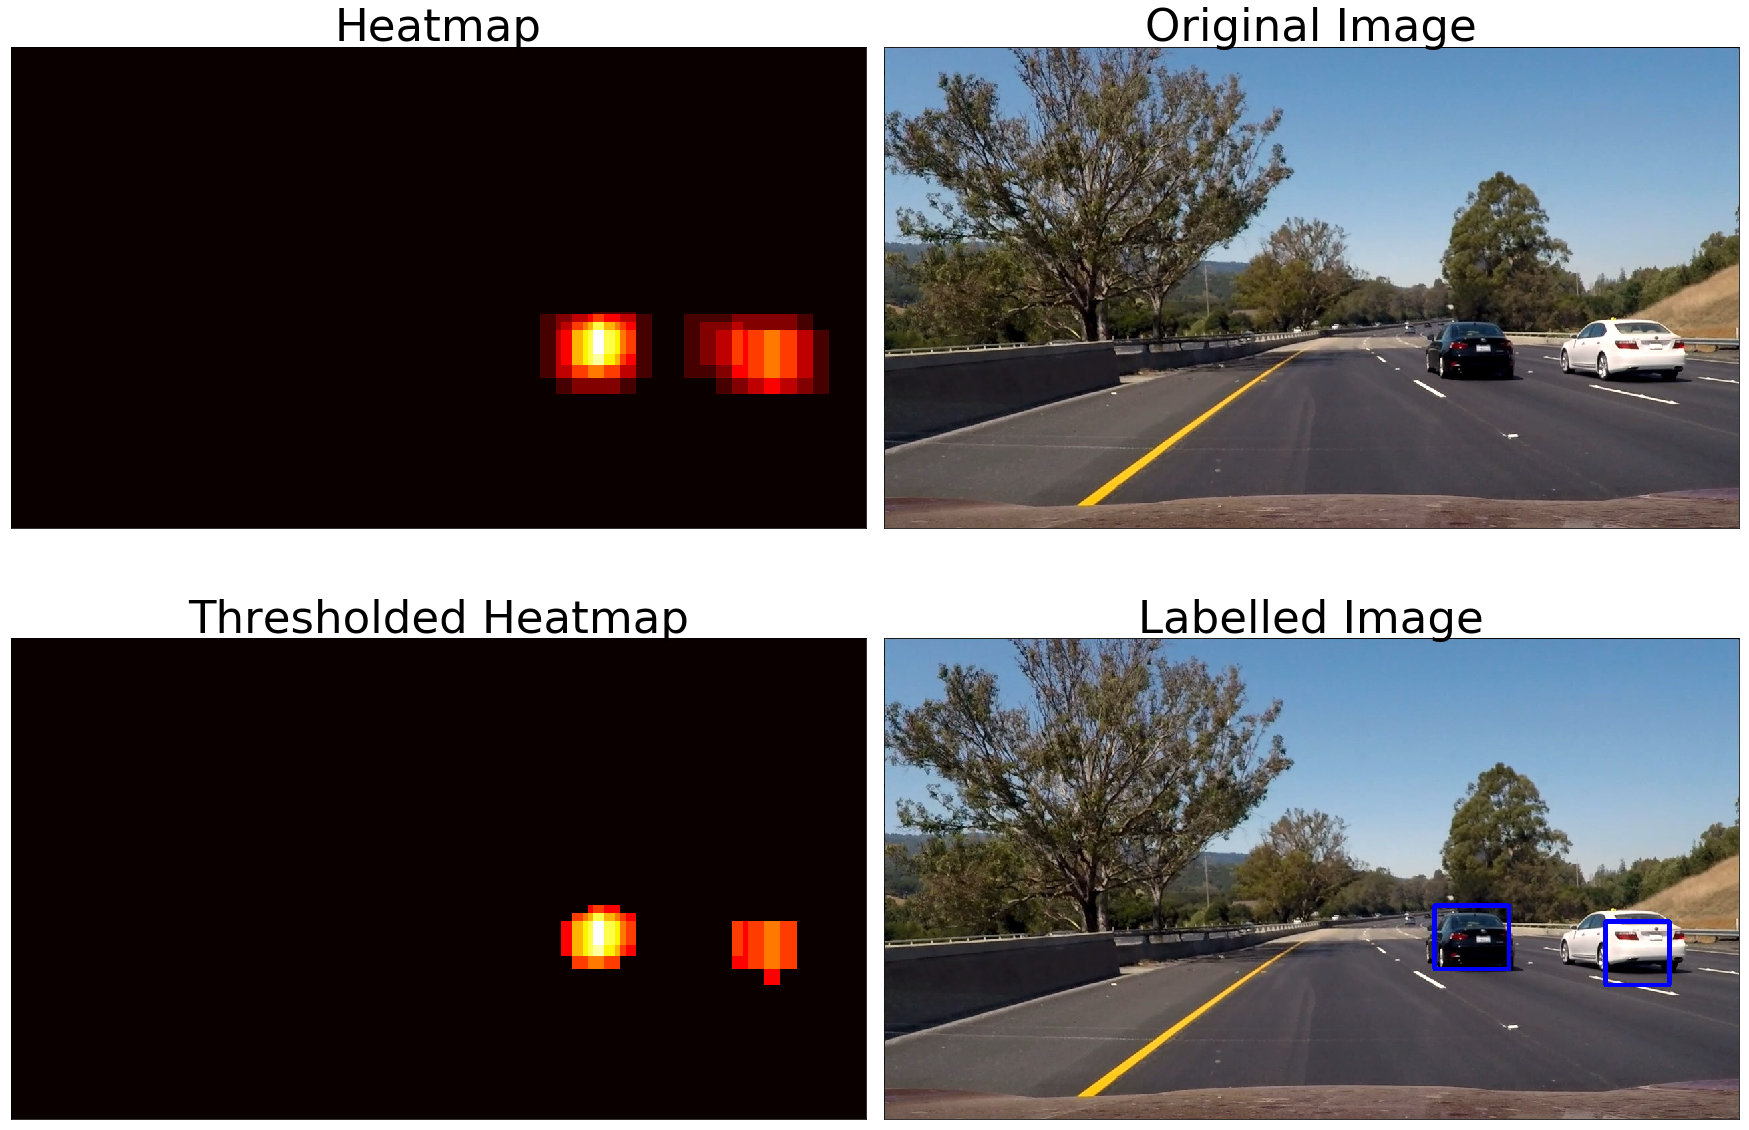

In [8]:
img = mpimg.imread('test_images/test6.jpg')
proc = Processor()

out = proc.find_vehicles(img)

## Heatmap
heatmap = proc.get_heatmap()

## Thresholded Heatmap
t_heatmap = proc.get_threshold_heatmap()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 18))
plt.setp((ax1, ax2, ax3, ax4),xticks=[],yticks=[])
f.tight_layout()
ax2.imshow(img)
ax2.set_title('Original Image', fontsize=45)
ax1.imshow(heatmap, cmap='hot')
ax1.set_title('Heatmap', fontsize=45)
ax3.imshow(t_heatmap, cmap='hot')
ax3.set_title('Thresholded Heatmap', fontsize=45)
ax4.imshow(out, cmap='hot')
ax4.set_title('Labelled Image', fontsize=45)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(t_start=30,t_end=35)
white_clip = clip.fl_image(proc.process)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output_without_lanes.mp4
[MoviePy] Writing video project_video_output_without_lanes.mp4


100%|█████████▉| 1260/1261 [08:33<00:00,  2.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_without_lanes.mp4 

CPU times: user 10min 33s, sys: 3.66 s, total: 10min 36s
Wall time: 8min 34s
